In [10]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import urllib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [11]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import urllib

# Load pretrained weights
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")

# Init ResNet18 for 365 classes
scene_model = models.resnet18(num_classes=365)
scene_model.fc = nn.Linear(scene_model.fc.in_features, 365)
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)
scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load scene labels (decode bytes → str)
url = "https://raw.githubusercontent.com/CSAILVision/places365/master/categories_places365.txt"
classes = [
    line.decode("utf-8").strip().split(" ")[0][3:]
    for line in urllib.request.urlopen(url)
]

In [12]:
# Create the database
PATH = "./data/places365/val/"
limit = 5
places = [e for e in os.listdir(PATH)]
rows=[]

for place in places:
    current_path = PATH + place
    for (i,file) in enumerate(os.listdir(current_path)):
        file_path = current_path + "/" + file
        img = cv2.imread(file_path)
        if i == limit:
            # print(f"Limit of {limit} reached for {place}")
            break
        rows.append({"image":img, "place":place})

df = pd.DataFrame(rows)
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
        

In [13]:
df["image"][0].shape

(256, 256, 3)

True Place: bookstore
Predictions:
  bookstore: 80.23%
  general_store/indoor: 6.65%
  drugstore: 3.00%
  pharmacy: 2.86%
  library/indoor: 2.03%


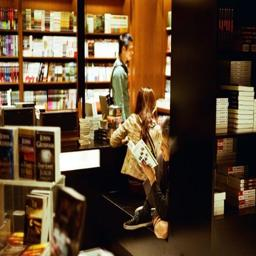

In [38]:
from IPython.display import display
import torch
import cv2
from PIL import Image
import random

def show_image_and_prediction(index):
    image = df["image"][index]
    place = df["place"][index]

    # Convert to PIL (OpenCV loads BGR)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Preprocess
    inputs = tf(image_pil).unsqueeze(0)  # Add batch dimension

    # Inference
    with torch.no_grad():
        logits = scene_model(inputs)
        probs = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Print true label
    print(f"True Place: {place}")
    print("Predictions:")

    # Print top 5 predictions sorted by probability
    top5_idx = torch.topk(probs, 5).indices
    for idx in top5_idx:
        label = classes[idx]
        prob = probs[idx].item() * 100
        print(f"  {label}: {prob:.2f}%")

    # Display image
    display(image_pil)

# Example
show_image_and_prediction(random.randint(0, len(df)-1))
